# Housing - exploratory data analysis (EDA)

NYC housing dataset b/w in 2012-13, seperated by boroughs

### The Unseen

- [] ..



In [43]:
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

pd.set_option('display.max_columns', 500)


In [44]:
# read all datasets w/ dates

raw_data = pd.read_csv('dataset/housing/rollingsales_manhattan.csv', parse_dates=['SALE DATE'], 
                       infer_datetime_format=True)
raw_data_bronx = pd.read_csv('dataset/housing/rollingsales_bronx.csv', parse_dates=['SALE DATE'], 
                             infer_datetime_format=True)
raw_data_brooklyn = pd.read_csv('dataset/housing/rollingsales_brooklyn.csv', parse_dates=['SALE DATE'], 
                                infer_datetime_format=True)
raw_data_queens = pd.read_csv('dataset/housing/rollingsales_queens.csv', parse_dates=['SALE DATE'], 
                              infer_datetime_format=True)
raw_data_statenisland = pd.read_csv('dataset/housing/rollingsales_statenisland.csv', parse_dates=['SALE DATE'], 
                                    infer_datetime_format=True)

# conembine all into 1
raw_data = raw_data.append([raw_data_bronx, raw_data_brooklyn, raw_data_queens, raw_data_statenisland], 
                           ignore_index=True)

# change column names
raw_data.columns = ['borough', 'neighborhood', 'building_class_category',
       'tax_class_at_present', 'block', 'lot', 'easement',
       'building_class_at_present', 'address', 'apartment_number',
       'zipcode', 'residential_units', 'commercial_units', 'total_units',
       'land_square_feet', 'gross_square_feet', 'year_built',
       'tax_class_at_sale', 'building_class_at_sale',
       'sale_price', 'sale_date']

raw_data['borough_name'] = raw_data['borough'].map({1:'Manhattan', 3:'Brooklyn', 2:'Bronx', 4:'Queens', 5:'Staten Island'})   

# change column names' order
raw_data = raw_data[['borough', 'borough_name' , 'neighborhood', 'building_class_category',
       'tax_class_at_present', 'tax_class_at_sale', 'block', 'lot', 'easement',
       'building_class_at_present', 'building_class_at_sale', 'address', 'apartment_number',
       'zipcode', 'residential_units', 'commercial_units', 'total_units',
       'land_square_feet', 'gross_square_feet', 'year_built',
       'sale_date', 'sale_price']]

raw_data.head()

,borough,borough_name,neighborhood,building_class_category,tax_class_at_present,tax_class_at_sale,block,lot,easement,building_class_at_present,building_class_at_sale,address,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,sale_date,sale_price
0,1,Manhattan,,13 CONDOS - ELEVATOR APARTMENTS,,2,738,1306,,,R4,345 WEST 14TH STREET,,10014,0,0,0,0,0,0,2013-05-20,"$2,214,693"
1,1,Manhattan,,13 CONDOS - ELEVATOR APARTMENTS,,2,738,1307,,,R4,345 WEST 14TH STREET,,10014,0,0,0,0,0,0,2013-05-16,"$1,654,656"
2,1,Manhattan,,13 CONDOS - ELEVATOR APARTMENTS,,2,738,1308,,,R4,345 WEST 14TH STREET,,10014,0,0,0,0,0,0,2013-05-23,"$1,069,162"
3,1,Manhattan,,13 CONDOS - ELEVATOR APARTMENTS,,2,738,1309,,,R4,345 WEST 14TH STREET,,10014,0,0,0,0,0,0,2013-05-15,"$1,374,637"
4,1,Manhattan,,13 CONDOS - ELEVATOR APARTMENTS,,2,738,1310,,,R4,345 WEST 14TH STREET,,10014,0,0,0,0,0,0,2013-05-13,"$1,649,565"


#### discover fields and values

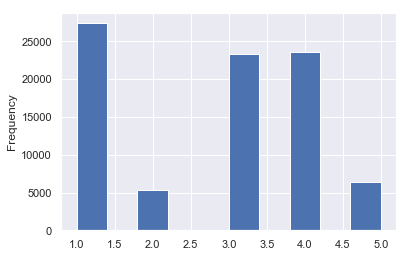

In [81]:
raw_data.borough.plot.hist()

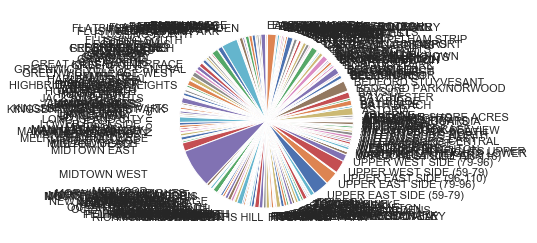

In [82]:
raw_data.groupby(raw_data.neighborhood).size().plot(kind='pie')

In [39]:
raw_data.land_square_feet.tail()

for col in ('land_square_feet', 'transaction_count'):
    data[col] = data[col].str.replace(r',', '').astype(int)

85970      2,590
85971      2,255
85972      4,000
85973     21,663
85974    489,656
Name: land_square_feet, dtype: object

In [45]:
raw_data.dtypes

borough                               int64
borough_name                         object
neighborhood                         object
building_class_category              object
tax_class_at_present                 object
tax_class_at_sale                    object
block                                 int64
lot                                   int64
easement                             object
building_class_at_present            object
building_class_at_sale               object
address                              object
apartment_number                     object
zipcode                               int64
residential_units                    object
commercial_units                     object
total_units                          object
land_square_feet                     object
gross_square_feet                    object
year_built                            int64
sale_date                    datetime64[ns]
sale_price                           object
dtype: object

In [38]:
type(3400000)

int

In [72]:
raw_data.describe(include='all')

,borough,borough_name,neighborhood,building_class_category,tax_class_at_present,tax_class_at_sale,block,lot,easement,building_class_at_present,building_class_at_sale,address,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,sale_date,sale_price
count,85975.000000,85975,85975,85975,85975,85975.0,85975.000000,85975.000000,85975,85975,85975,85975,85975,85975.000000,85975,85975.0,85975,85975,85975,85975.000000,85975,85975
unique,NaN,5,257,40,11,8.0,NaN,NaN,2,170,170,63419,4492,NaN,261,81.0,273,6245,6539,NaN,386,10222
top,NaN,Manhattan,MIDTOWN WEST,01 ONE FAMILY HOMES,2,2.0,NaN,NaN,,D4,D4,870 7 AVENUE,,NaN,0,0.0,1,0,0,NaN,2012-09-27 00:00:00,$0
freq,NaN,27395,6264,14846,32899,36960.0,NaN,NaN,85973,13461,13461,2087,63830,NaN,24544,55360.0,25991,40340,42780,NaN,988,26959
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-08-01 00:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-08-26 00:00:00,NaN
mean,2.723606,NaN,NaN,NaN,NaN,NaN,3661.041721,405.420541,NaN,NaN,NaN,NaN,NaN,10758.035254,NaN,NaN,NaN,NaN,NaN,1681.403303,NaN,NaN
std,1.352580,NaN,NaN,NaN,NaN,NaN,3404.028873,652.166743,NaN,NaN,NaN,NaN,NaN,662.101399,NaN,NaN,NaN,NaN,NaN,670.796500,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,1.000000,NaN,NaN,NaN,NaN,NaN,1052.000000,23.000000,NaN,NaN,NaN,NaN,NaN,10028.000000,NaN,NaN,NaN,NaN,NaN,1910.000000,NaN,NaN
